# **Project 3:** Malicious or Phishing vs Safe URL Detection

### Importing the Libraries

In [1]:
import numpy as np  
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,cross_val_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report,roc_curve,confusion_matrix
from sklearn import metrics
from xgboost import XGBClassifier
import joblib
sns.set()

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [3]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

## Task 1: Exploratory Data Analysis:

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Read the data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SampleData/dataset.csv')

In [7]:
## Checking some sample data
data.head()

,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,1,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,2,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,3,1,0,1,1,1,-1,-1,-1,-1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,4,1,0,1,1,1,-1,-1,-1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,5,1,0,-1,1,1,-1,1,1,-1,...,-1,1,-1,-1,0,-1,1,1,1,1


### Based upon the above data, let we understand the columns properly.

## Domain Analysis

## URL Components 
The figure below shows relevant parts in the structure of a typical URL.

![Picture1.png](Picture1.png)

### Dataset description
There are 4 types of features that we can extract from the URL.<br>

Address Bar based Features<br>
Abnormal Based Features<br>
HTML and JavaScript based Features<br>
Domain based Features

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11055 entries, 0 to 11054
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   index                        11055 non-null  int64
 1   having_IPhaving_IP_Address   11055 non-null  int64
 2   URLURL_Length                11055 non-null  int64
 3   Shortining_Service           11055 non-null  int64
 4   having_At_Symbol             11055 non-null  int64
 5   double_slash_redirecting     11055 non-null  int64
 6   Prefix_Suffix                11055 non-null  int64
 7   having_Sub_Domain            11055 non-null  int64
 8   SSLfinal_State               11055 non-null  int64
 9   Domain_registeration_length  11055 non-null  int64
 10  Favicon                      11055 non-null  int64
 11  port                         11055 non-null  int64
 12  HTTPS_token                  11055 non-null  int64
 13  Request_URL                  11055 non-null  i

In [9]:
data.columns

Index(['index', 'having_IPhaving_IP_Address', 'URLURL_Length',
       'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting',
       'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State',
       'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token',
       'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH',
       'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover',
       'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord',
       'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page',
       'Statistical_report', 'Result'],
      dtype='object')

***This markdown refer to Phishing website features to get details about the each features of our data***

### Let we understand about our data features

1) **having_IPhaving_IP_Address:** If the IP address is used, the indication might be the URL trying to trick user and steal some information.<br>
If domain have IP address then-> Phishing(-1)<br>
Else-> Legitimate (1)<br>
2) **URL_Length:** Many times phisher may hide suspecious information in URL itself, if the URL is of very long size.<br>
So, if URL length < 54 -> Legitimate (1)<br>
URL length 54 to 75 -> suspecious (0)<br>
Else -> Phishing(-1)<br>
3) **Shortining_ServiceShortining_Service:** Using HTTP redifrect short url could also lead to phishing websites.<br>
Tiny URL-> -1<br>
Else -> 1<br>
4) **having_At_Symbol:** URL with @ symbol -> -1 else 1<br>
5) **double_slash_redirecting:** doble slash means user may redirected to another website. Like <br>```https://safeurl.com//phishingURL.com``` So, // -> -1 else 1<br>
6) **Prefix_Suffix:** Dash is rarely used in URL. So, presence of (-) -> -1 else 1<br>
7) **having_Sub_Domain:** If the URL have one sub domain like one dot it means its legitimate, if more than 1 or less than 2 it means suspecious else phishing.<br>
8) **SSLfinal_State:** We can also check the age of certificate installed. So if the age is more than 1 year legitimate (1), if https and Isuuer not trusted then suspecious(0) else Phishing(-1)<br>
9) **Domain_registeration_length:** If the domain expired within 1 year it means phishing else legitimate.<br>
10) **Favicon:** Fevicon is the graphical image in specific webpage. If the fevicon is from other source then it is phishing else legitimate.<br>
11) **Port:** If the ports are open phishers can attack your system with any system they want. So Port number is of preferred status -> Phishing else -> Legitimate<br>
12) **HTTPS_token:** Like url ```http://https-www.safe-url.com``` In such URL phishers may want to trick user so http taken url is phishing else legitimate.<br>
13) **Request_URL:** In safe url most of the object embedded in same URL. So, % of request URL < 22% -> legitimate (1)  if 22 to 61 % then suspecious else Phishing.<br>
14) **URL_of_Anchor:** In this we check ```<a>``` If this tag contains different domain then this is same as Request URL.So,
% of URL of anchors < 31% -> Legitimate<br>
Between 31 to 67 -> suspecious<br>
Else -> Phishing<br>
15) **Links_in_tags:** % of Links in ```"<Meta>","<Script>" and "<"Link>\""```<17%  → Legitimate,<br>
% of Links in ```<Meta>","<Script>" and "<"Link>\"" ≥17% And≤81%``` → Suspicious<br>
Else-> Phishing<br>
16) **SFH:** SFH is "about: blank\"" Or Is Empty → Phishing (-1) <br>
SFH "Refers To " A Different Domain→ Suspicious (0) <br>
Else -> 1<br>
17) **Submitting_to_email:** Webform may ask user to submit information that is directed to a server for processing. So, Using <br>```"mail()\" or \"mailto:\" Function to Submit User Information"```→ Phishing else -> Legitimate.<br>
18) **Abnormal_URL:** The Host Name Is Not Included In URL → Phishing, Else -> legitimate.<br>
19) **Redirect:** It is how many times a URL is redirected to other URL. ofRedirect Page≤1 → Legitimate,of Redirect Page≥2 <br> &And<4→ Suspicious, else -> Phishing.<br>
20) **RightClick:** Sometime if the right click is diabled is becuase phisher don't want you to open any tab.<br>
Right Click Disabled → Phishing <br>
Otherwise→Legitimate<br>
21) **on_mouseover:** MouseOver Changes Status Bar→ Phishing, Does't Change Status Bar→Legitimate<br>
22) **popUpWidnow:** Popoup window asks for text fields → Phishing, Else -> legitimate<br>
23) **Iframe:** If the HTML tag use to show aditional webpage, phisher can use iframe tag. Using iframe→ Phishing <br>
Else -> Legitimate<br>
24) **age_of_domain:** Age of domain > 6 months Legitimate, else-> Phishing<br>
25) **DNSRecord:** No DNS record -> Phishing, Else -> legitimate<br>
26) **web_traffic:** This feature use to test popularity of the websites. Website Rank<100,000 → Legitimate, if Website <br>Rank>100,000 →Suspicious, else -> Phishing<br>
27) **Page_Rank:** Page range is how important a webpage is for internet. PageRank<0.2 → Phishing, Otherwise → Legitimate<br>
28) **Google_Index:**  This feature is whether is website is coming in google index or not. Webpage Indexed by <br>Google → Legitimate, else -> Phishing<br>
29) **Links_pointing_to_page:** Webpage Indexed by Google → Legitimate, Webpage Indexed by Google → Legitimate, else -> legitimate<br>
30) **Statistical_report:** Host Belongs to Top Phishing IPs or Top Phishing Domains -> phishing, else -> legitimate<br>
31) **Result:** It is the actual value which suggest us whather the URL is phishing or legitimate based upon the feature we have.  This is out Target Column.<br>

In [17]:
data.columns

Index(['index', 'having_IPhaving_IP_Address', 'URLURL_Length',
       'Shortining_Service', 'having_At_Symbol', 'double_slash_redirecting',
       'Prefix_Suffix', 'having_Sub_Domain', 'SSLfinal_State',
       'Domain_registeration_length', 'Favicon', 'port', 'HTTPS_token',
       'Request_URL', 'URL_of_Anchor', 'Links_in_tags', 'SFH',
       'Submitting_to_email', 'Abnormal_URL', 'Redirect', 'on_mouseover',
       'RightClick', 'popUpWidnow', 'Iframe', 'age_of_domain', 'DNSRecord',
       'web_traffic', 'Page_Rank', 'Google_Index', 'Links_pointing_to_page',
       'Statistical_report', 'Result'],
      dtype='object')

In [11]:
## Number of samples and features
data.shape

(11055, 32)

The data set has 11055 samples and 32 features.  

Let we check the unique value in each columns in the data

Displaying all unique elements if the column has less than or equal to 10 unique elements.  Othewise, only printing the number of unique elements.
 

In [19]:
print("Unique elements in Result Column: ", data.Result.unique())
print("Length of Unique elements in Result column:",data.Result.nunique())

Unique elements in Result Column:  [-1  1]
Length of Unique elements in Result column: 2


In [13]:
## Displaying all unique elements if the column has less than or equal to 10 unique elements.  
## Othewise, only printing the number of unique elements.
 
for col in data.columns:
    unique_value_list = data[col].unique()
    if len(unique_value_list) > 10:
        print(f'{col} has {data[col].nunique()} unique values')
    else:
        print(f'{col} contains:\t\t\t{unique_value_list}')

index has 11055 unique values
having_IPhaving_IP_Address contains:			[-1  1]
URLURL_Length contains:			[ 1  0 -1]
Shortining_Service contains:			[ 1 -1]
having_At_Symbol contains:			[ 1 -1]
double_slash_redirecting contains:			[-1  1]
Prefix_Suffix contains:			[-1  1]
having_Sub_Domain contains:			[-1  0  1]
SSLfinal_State contains:			[-1  1  0]
Domain_registeration_length contains:			[-1  1]
Favicon contains:			[ 1 -1]
port contains:			[ 1 -1]
HTTPS_token contains:			[-1  1]
Request_URL contains:			[ 1 -1]
URL_of_Anchor contains:			[-1  0  1]
Links_in_tags contains:			[ 1 -1  0]
SFH contains:			[-1  1  0]
Submitting_to_email contains:			[-1  1]
Abnormal_URL contains:			[-1  1]
Redirect contains:			[0 1]
on_mouseover contains:			[ 1 -1]
RightClick contains:			[ 1 -1]
popUpWidnow contains:			[ 1 -1]
Iframe contains:			[ 1 -1]
age_of_domain contains:			[-1  1]
DNSRecord contains:			[-1  1]
web_traffic contains:			[-1  0  1]
Page_Rank contains:			[-1  1]
Google_Index contains:			[ 1 -1]
L

#### Checking the missing values

In [14]:
data.isnull().sum()

index                          0
having_IPhaving_IP_Address     0
URLURL_Length                  0
Shortining_Service             0
having_At_Symbol               0
double_slash_redirecting       0
Prefix_Suffix                  0
having_Sub_Domain              0
SSLfinal_State                 0
Domain_registeration_length    0
Favicon                        0
port                           0
HTTPS_token                    0
Request_URL                    0
URL_of_Anchor                  0
Links_in_tags                  0
SFH                            0
Submitting_to_email            0
Abnormal_URL                   0
Redirect                       0
on_mouseover                   0
RightClick                     0
popUpWidnow                    0
Iframe                         0
age_of_domain                  0
DNSRecord                      0
web_traffic                    0
Page_Rank                      0
Google_Index                   0
Links_pointing_to_page         0
Statistica

No missing values found, so no need to drop or replace any value

**According to the Data descrition, these are the meaning of the values in the data**
<br>
1 means legitimate<br>
0 is suspicious<br>
-1 is phishing<br>

In [20]:
data.describe()  ## Displaying some summary statistics

,index,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
count,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,...,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000,11055.000000
mean,5528.000000,0.313795,-0.633198,0.738761,0.700588,0.741474,-0.734962,0.063953,0.250927,-0.336771,...,0.613388,0.816915,0.061239,0.377114,0.287291,-0.483673,0.721574,0.344007,0.719584,0.113885
std,3191.447947,0.949534,0.766095,0.673998,0.713598,0.671011,0.678139,0.817518,0.911892,0.941629,...,0.789818,0.576784,0.998168,0.926209,0.827733,0.875289,0.692369,0.569944,0.694437,0.993539
min,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,2764.500000,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,-1.000000
50%,5528.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
75%,8291.500000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,11055.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


drop the index column because that acts as a primary key and has no significance in EDA and modelling

In [21]:
data = data.drop(columns=['index'])

In [22]:
## Checking the value counts.  i.e. checking the count of each category.
data['Result'].value_counts()

 1    6157
-1    4898
Name: Result, dtype: int64

In [23]:
## Percentage of Target classes
round(data['Result'].value_counts(normalize=True) *100, 2)


 1    55.69
-1    44.31
Name: Result, dtype: float64

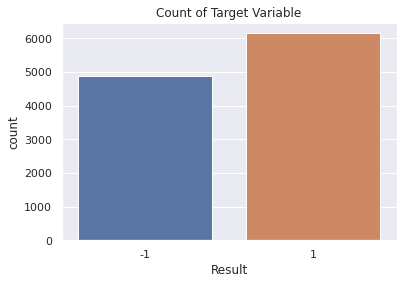

In [25]:
## Visualizing the target variable count
sns.countplot(x = data['Result'])
plt.title("Count of Target Variable")
plt.show()

In the given dataset, all the features are categorical features.  So, Count Plot is an appropriate visualition than Histogram

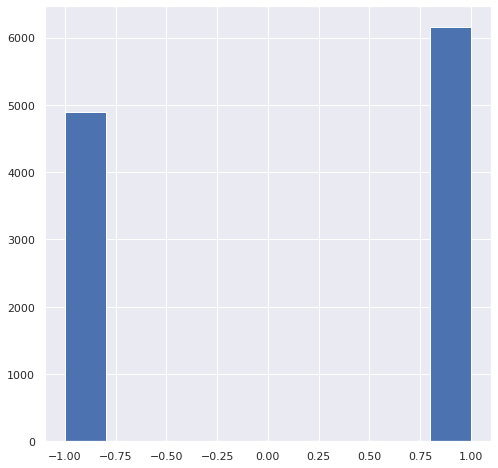

In [18]:
# Plot distribution of classes using Histograms
plt.figure(figsize =(8,8))
plt.hist(data.Result)  
plt.show()

## Task2: Correlation of features and feature selection:

In [19]:
# Generate correlation matrix
data.corr() 

,having_IPhaving_IP_Address,URLURL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
having_IPhaving_IP_Address,1.000000,-0.052411,0.403461,0.158699,0.397389,-0.005257,-0.080745,0.071414,-0.022739,0.087025,...,0.096882,0.054694,-0.010446,-0.050733,0.002922,-0.091774,0.029153,-0.339065,-0.019103,0.094160
URLURL_Length,-0.052411,1.000000,-0.097881,-0.075108,-0.081247,0.055247,0.003997,0.048754,-0.221892,-0.042497,...,-0.049381,-0.013838,0.179426,-0.040823,0.008993,0.183518,0.002902,-0.022987,-0.067153,0.057430
Shortining_Service,0.403461,-0.097881,1.000000,0.104447,0.842796,-0.080471,-0.041916,-0.061426,0.060923,0.006101,...,0.036616,0.016581,-0.052596,0.436064,-0.047074,0.014591,0.155844,-0.198410,0.085461,-0.067966
having_At_Symbol,0.158699,-0.075108,0.104447,1.000000,0.086960,-0.011726,-0.058976,0.031220,0.015522,0.304899,...,0.290893,0.284410,-0.005499,-0.047872,0.032918,-0.064735,0.037061,-0.006080,-0.080357,0.052948
double_slash_redirecting,0.397389,-0.081247,0.842796,0.086960,1.000000,-0.085590,-0.043079,-0.036200,0.047464,0.035100,...,0.054463,0.010459,-0.050107,0.431409,-0.062369,-0.003132,0.178415,-0.194165,0.070390,-0.038608
Prefix_Suffix,-0.005257,0.055247,-0.080471,-0.011726,-0.085590,1.000000,0.087891,0.261391,-0.096799,-0.007504,...,-0.014733,-0.036904,0.074116,-0.016556,0.110598,-0.006834,0.067781,0.067423,-0.002763,0.348606
having_Sub_Domain,-0.080745,0.003997,-0.041916,-0.058976,-0.043079,0.087891,1.000000,0.267649,-0.082839,-0.016704,...,-0.025312,0.010637,0.119254,0.125493,-0.005764,0.120730,0.057673,-0.010526,0.081627,0.298323
SSLfinal_State,0.071414,0.048754,-0.061426,0.031220,-0.036200,0.261391,0.267649,1.000000,-0.193622,-0.014757,...,-0.013005,-0.002773,0.162809,0.050972,0.258768,0.074545,0.096051,-0.011710,0.063411,0.714741
Domain_registeration_length,-0.022739,-0.221892,0.060923,0.015522,0.047464,-0.096799,-0.082839,-0.193622,1.000000,0.054253,...,0.051410,0.004393,-0.062851,-0.010477,-0.134454,-0.059898,-0.039766,0.122672,-0.002212,-0.225789
Favicon,0.087025,-0.042497,0.006101,0.304899,0.035100,-0.007504,-0.016704,-0.014757,0.054253,1.000000,...,0.939633,0.627607,-0.002628,0.088211,-0.050922,0.011699,-0.016668,-0.127243,0.300917,-0.000280


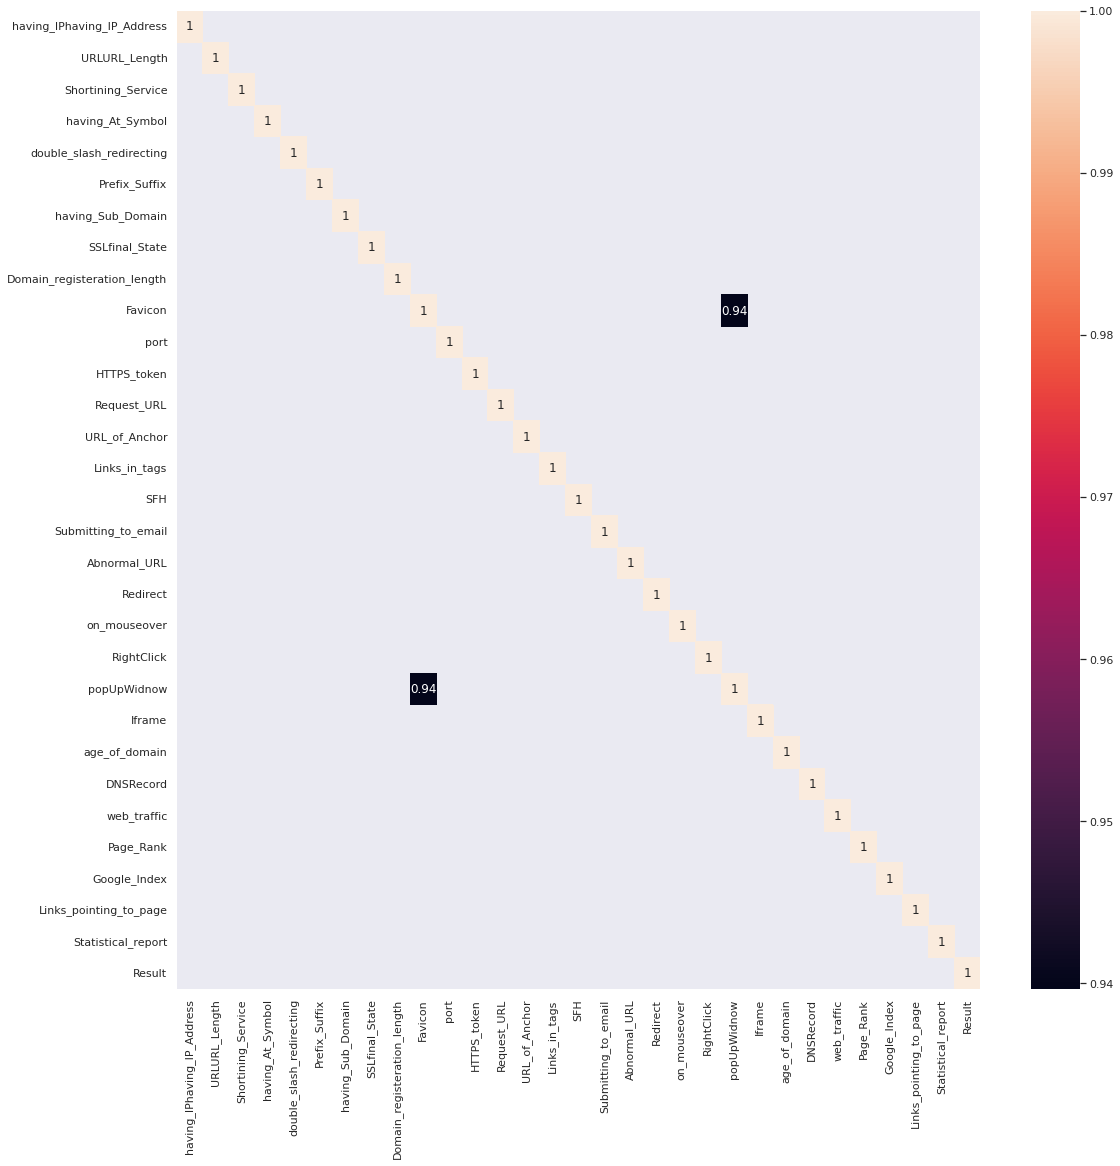

In [29]:
## Checkingthe correlation using heatmap.  Let us use the threshold to check the correlated features.
## Threshold = .90
plt.figure(figsize =(18,18))
cor = abs(data.corr())
sns.heatmap(cor[cor > .90], annot=True) 
plt.show()

Note that feature popUpWindow and favicon are highly correlated. Looking at the definitions of these features from the Data description, we can say that, for websites where favicon is loaded from external links the pop-up window mostly contains text field. This is said just by seeing the high correlation. Dropping one of the features or not is an experimental decision

Note that some features are negatively correlated but the color index minimum correlation is upto -0.6. Negative correlations are where one feature marks it as phishing and other don't.

In [25]:
# Print correlation with target variable
data.corr()['Result'].sort_values()    

Domain_registeration_length   -0.225789
Shortining_Service            -0.067966
Abnormal_URL                  -0.060488
HTTPS_token                   -0.039854
double_slash_redirecting      -0.038608
Redirect                      -0.020113
Iframe                        -0.003394
Favicon                       -0.000280
popUpWidnow                    0.000086
RightClick                     0.012653
Submitting_to_email            0.018249
Links_pointing_to_page         0.032574
port                           0.036419
on_mouseover                   0.041838
having_At_Symbol               0.052948
URLURL_Length                  0.057430
DNSRecord                      0.075718
Statistical_report             0.079857
having_IPhaving_IP_Address     0.094160
Page_Rank                      0.104645
age_of_domain                  0.121496
Google_Index                   0.128950
SFH                            0.221419
Links_in_tags                  0.248229
Request_URL                    0.253372


Let we just select those volumns which is relavent in the better model making.

## Separating the data as features and target.

In [30]:
X = data.iloc[:,[0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 27, 29]].values
y = data.iloc[:,-1].values

In [31]:
## Splitting the data.
## 80% for Training and 20% for Testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Task 3: Building classification:

In [38]:
## Independent Logistic Regression Model
lr = LogisticRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

## Model Metrics
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

          -1       0.86      0.87      0.86       950
           1       0.90      0.89      0.90      1261

    accuracy                           0.88      2211
   macro avg       0.88      0.88      0.88      2211
weighted avg       0.88      0.88      0.88      2211



In [40]:
## Independent RF Model
rf = RandomForestClassifier()

rf.fit(X_train, y_train)
y_rf_pred = rf.predict(X_test)

## Model Metrics
print(classification_report(y_rf_pred, y_test))

              precision    recall  f1-score   support

          -1       0.92      0.94      0.93       929
           1       0.96      0.94      0.95      1282

    accuracy                           0.94      2211
   macro avg       0.94      0.94      0.94      2211
weighted avg       0.94      0.94      0.94      2211



In [33]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(kernel = 'rbf')))
models.append(('RF', RandomForestClassifier()))
models.append(('XGB',XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', nthread=1)))

In [34]:
print(models)

[('LR', LogisticRegression()), ('LDA', LinearDiscriminantAnalysis()), ('KNN', KNeighborsClassifier()), ('CART', DecisionTreeClassifier()), ('NB', GaussianNB()), ('SVM', SVC()), ('RF', RandomForestClassifier()), ('XGB', XGBClassifier(learning_rate=0.02, n_estimators=600, nthread=1))]


In [39]:
# evaluate each model in turn
results = []
names = []
seed = 42
scoring = 'accuracy'
for name, model in models:
    kfold = KFold(n_splits=5, shuffle = True,random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "Model Name: %s, Mean Accuracy:  %f, Standard Error:  (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Model Name: LR, Mean Accuracy:  0.884667, Standard Error:  (0.005089)
Model Name: LDA, Mean Accuracy:  0.877996, Standard Error:  (0.006552)
Model Name: KNN, Mean Accuracy:  0.892017, Standard Error:  (0.010337)
Model Name: CART, Mean Accuracy:  0.924920, Standard Error:  (0.006923)
Model Name: NB, Mean Accuracy:  0.584013, Standard Error:  (0.012423)
Model Name: SVM, Mean Accuracy:  0.917231, Standard Error:  (0.005319)
Model Name: RF, Mean Accuracy:  0.933062, Standard Error:  (0.007284)
Model Name: XGB, Mean Accuracy:  0.913048, Standard Error:  (0.007532)


In [ ]:
X_train.shape

(8844, 22)

In [41]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(50, input_dim=22, activation='relu'))
    model.add(Dense(40,activation='relu'))
    model.add(Dense(30,activation='relu'))
    model.add(Dense(20,activation='relu'))
    model.add(Dense(10,activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [42]:
np.unique(y_train)

array([-1,  1])

In [43]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=50, batch_size=20, verbose=1)
kfold = KFold(n_splits=5, shuffle=True)
result = cross_val_score(estimator, X_train,y_train , cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (result.mean()*100, result.std()*100))

<ipython-input-43-8ac46761ac1d>:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=baseline_model, epochs=50, batch_size=20, verbose=1)


Epoch 1/50
354/354 [==============================] - 2s 2ms/step - loss: 0.3244 - accuracy: 0.8570
Epoch 2/50
354/354 [==============================] - 1s 2ms/step - loss: 0.2205 - accuracy: 0.9042
Epoch 3/50
354/354 [==============================] - 1s 2ms/step - loss: 0.1981 - accuracy: 0.9142
Epoch 4/50
354/354 [==============================] - 1s 2ms/step - loss: 0.1835 - accuracy: 0.9206
Epoch 5/50
354/354 [==============================] - 1s 2ms/step - loss: 0.1768 - accuracy: 0.9223
Epoch 6/50
354/354 [==============================] - 1s 2ms/step - loss: 0.1688 - accuracy: 0.9247
Epoch 7/50
354/354 [==============================] - 1s 2ms/step - loss: 0.1605 - accuracy: 0.9300
Epoch 8/50
354/354 [==============================] - 1s 2ms/step - loss: 0.1535 - accuracy: 0.9339
Epoch 9/50
354/354 [==============================] - 1s 2ms/step - loss: 0.1500 - accuracy: 0.9312
Epoch 10/50
354/354 [==============================] - 1s 2ms/step - loss: 0.1471 - accuracy: 0.9355

Based Upon the Result Random forest is performing well. Let's tune the parameter for further better accuracy

In [45]:
from sklearn.model_selection import GridSearchCV
# Create parameter grid based on the results of the random search 
param_grid1 = {
    'max_depth': [50,80, 90, 100, 110]
}
param_grid2 ={
    'min_samples_leaf': [1,2,3,4,5]
}
param_grid3 ={
    'min_samples_split': [2,4,6,8,10]
}
param_grid4 ={
    'n_estimators': [50,100, 200, 300, 1000]
}

To speed up, You can take parameter grid each one at a time. If you take all at once it may take several minutes depending on the data and complexity of your parameter to train.

In [46]:
# Instantiate the grid search model
clf = RandomForestClassifier(max_depth= 90,min_samples_leaf=1,min_samples_split=2,n_estimators=200)
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid4, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


{'n_estimators': 1000}

Upon training we can find that the best parameter:<br>
{'bootstrap': True,<br>
 'max_depth': 90,<br>
 'max_features': 3,<br>
 'min_samples_leaf': 3,<br>
 'min_samples_split': 10,<br>
 'n_estimators': 300}

Let we just compare the base model vs Grid model to compare the accuracy.

In [47]:
base_model = RandomForestClassifier()
grid_model = RandomForestClassifier(max_depth= 90,min_samples_leaf=1,min_samples_split=2,n_estimators=200)

In [48]:
base_model.fit(X_train,y_train)
grid_model.fit(X_train,y_train)

RandomForestClassifier(max_depth=90, n_estimators=200)

In [ ]:
print("Base Accuracy : {}".format(accuracy_score(base_model.predict(X_test),y_test)))
print("Grid Model: {}".format(accuracy_score(grid_model.predict(X_test),y_test)))

Base Accuracy : 0.9384893713251922
Grid Model: 0.939846223428313


In [49]:
prediction = grid_model.predict(X_test)

In [51]:
print(classification_report(prediction, y_test))

              precision    recall  f1-score   support

          -1       0.92      0.94      0.93       932
           1       0.95      0.94      0.95      1279

    accuracy                           0.94      2211
   macro avg       0.93      0.94      0.94      2211
weighted avg       0.94      0.94      0.94      2211



Conf matrix Random Forest: [[ 875   81]
 [  57 1198]]


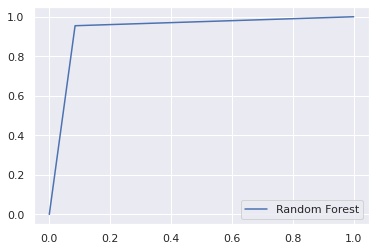

In [50]:
fpr,tpr,thresh = roc_curve(y_test,prediction)
roc_auc = accuracy_score(y_test,prediction)

# Plot ROC curve for Random-forest
plt.plot(fpr,tpr,'b',label = 'Random Forest')
plt.legend(loc ='lower right')
print("Conf matrix Random Forest:",confusion_matrix(y_test,prediction))
plt.show()

To check if our model is not overfitting let we check about the KFold cross validation.

In [ ]:
seed = 42
scoring = "accuracy"
kfold_grid = KFold(n_splits=10, shuffle = True,random_state=seed)
cv_results_grid = cross_val_score(grid_model, X_train, y_train, cv=kfold_grid, scoring=scoring)

In [ ]:
print("%s: %f (%f)" % ("Random Forest", cv_results_grid.mean()*100, cv_results_grid.std()*100))

Random Forest: 93.634226 (1.081400)


Since we are using Random forest, let we check each feature importance in tree.

In [52]:
importances = grid_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in grid_model.estimators_], axis=0)

In [53]:
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 11 (0.379056)
2. feature 19 (0.106669)
3. feature 6 (0.105431)
4. feature 5 (0.066593)
5. feature 12 (0.063439)
6. feature 13 (0.032827)
7. feature 10 (0.031297)
8. feature 7 (0.027318)
9. feature 17 (0.025647)
10. feature 0 (0.022584)
11. feature 20 (0.021041)
12. feature 18 (0.020904)
13. feature 1 (0.013350)
14. feature 8 (0.013159)
15. feature 14 (0.010419)
16. feature 21 (0.009749)
17. feature 9 (0.009650)
18. feature 2 (0.009471)
19. feature 3 (0.009393)
20. feature 15 (0.008678)
21. feature 4 (0.006809)
22. feature 16 (0.006515)


In [ ]:
pred=grid_model.predict(X_test)
print(classification_report(y_test, pred))
print('The accuracy is:', accuracy_score(y_test, pred))
print(metrics.confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

          -1       0.94      0.92      0.93       956
           1       0.94      0.96      0.95      1255

    accuracy                           0.94      2211
   macro avg       0.94      0.94      0.94      2211
weighted avg       0.94      0.94      0.94      2211

The accuracy is: 0.939846223428313
[[ 879   77]
 [  56 1199]]


In [ ]:
# save the model to disk
filename = 'classifier/finalized_model.sav'
joblib.dump(grid_model, filename)

['classifier/finalized_model.sav']